# DSP Project: Wireless Transmitter using ADALM-PLUTO SDR

## Installation Commands
Run the following commands to install necessary Python libraries (if not already installed):
```bash
pip install numpy scipy matplotlib pyadi-iio
```

---
## 1. Introduction
This project demonstrates how to build a basic wireless BPSK transmitter and receiver using Python, GNU Radio (optional), and ADALM-PLUTO SDR. The task includes:
- Signal generation and modulation (Tx)
- Signal filtering and demodulation (Rx)
- Working with SDR via PyADI


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, freqz
from scipy.fft import fft, fftfreq, fftshift


# ------------------------------------------------
# 1. Given Parameters
# ------------------------------------------------

fs = 50000  # Sampling frequency (Hz)
data_rate = 9600  # bits per second
fc = 169e6  # Carrier frequency (Hz)
samples_per_symbol = int(fs / data_rate)
num_bits = 1000  # Number of bits to transmit
bit_duration = 1 / data_rate
stopband_freq = 25000
cutoff_freq = 10000
passband_ripple = 0.05  # dB
stopband_atten = 60  # dB
quantization_bits = 8

# Time array
time = np.arange(0, num_bits * bit_duration, 1/fs)

## 2. Signal Generation (Transmitter)
### BPSK Theory:
In BPSK, each bit is mapped to a symbol (+1 or -1). This baseband signal is later used for pulse shaping and transmission.

**Formula:**
\[ s(t) = \sum a_k p(t - kT) \]
where \( a_k \in \{-1, +1\} \) and \( p(t) \) is the pulse shape (rectangular or shaped).

The output is passed to the SDR as a complex signal (I + jQ), and the SDR performs upconversion to RF.

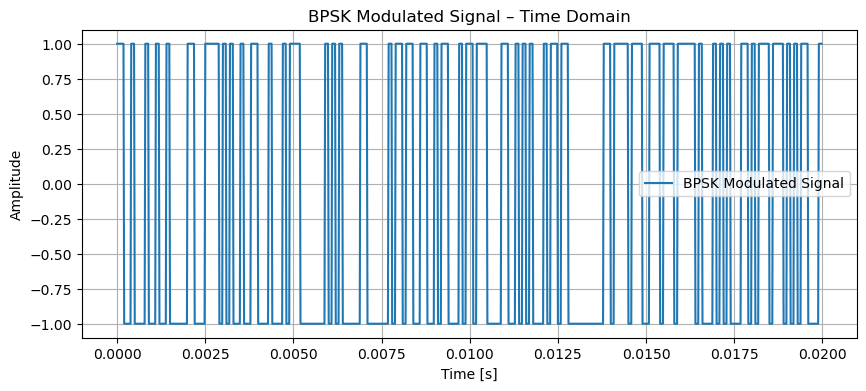

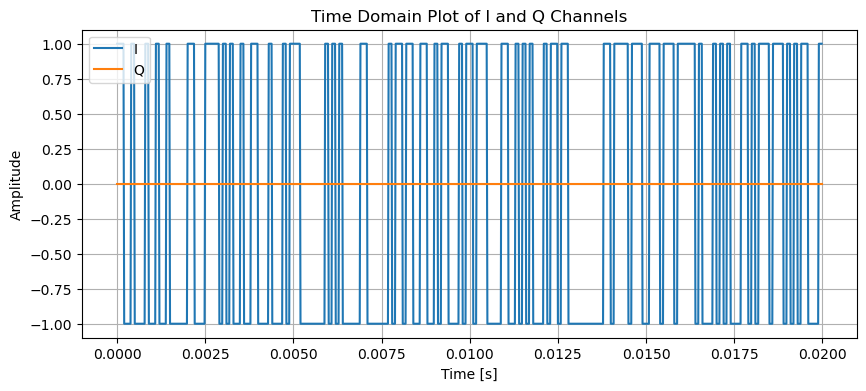

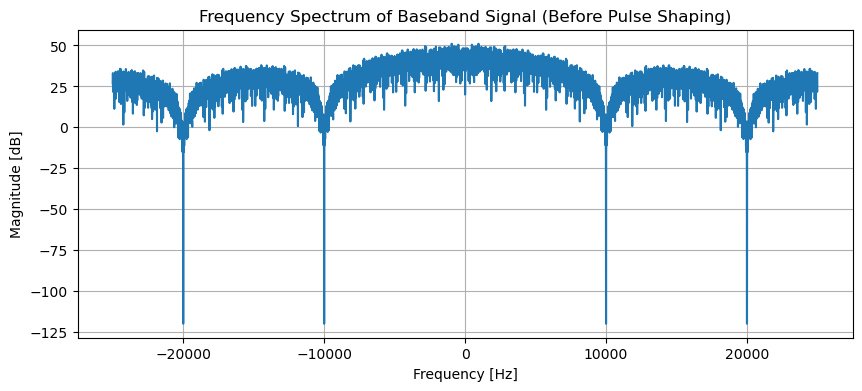

In [29]:
# ------------------------------------------------
# 2. SIGNAL GENERATION
# ------------------------------------------------
# Generate random bits and BPSK modulation
bits = np.random.randint(0, 2, num_bits)
symbols = 2 * bits - 1  # BPSK: 0 -> -1, 1 -> +1

# Upsample symbols
tx_signal = np.repeat(symbols, samples_per_symbol)

# --- BPSK Modulated Signal (Time Domain) ---
plt.figure(figsize=(10, 4))
plt.plot(time[:1000], tx_signal[:1000], label='BPSK Modulated Signal')
plt.title('BPSK Modulated Signal – Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# I/Q mapping
i_signal = tx_signal
q_signal = np.zeros_like(i_signal)SDR TRANSMIT CODE

# --- Time domain plot of I and Q ---
plt.figure(figsize=(10, 4))
plt.plot(time[:1000], i_signal[:1000], label='I')
plt.plot(time[:1000], q_signal[:1000], label='Q')
plt.title('Time Domain Plot of I and Q Channels')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# --- Frequency domain before pulse shaping ---
N = len(i_signal)
freqs = fftfreq(N, 1/fs)
fft_signal = fft(i_signal)
plt.figure(figsize=(10, 4))
plt.plot(fftshift(freqs), 20*np.log10(np.abs(fftshift(fft_signal)) + 1e-6))
plt.title('Frequency Spectrum of Baseband Signal (Before Pulse Shaping)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.show()


## 3. Pulse Shaping
We use a Hamming-windowed FIR filter for pulse shaping to reduce bandwidth and intersymbol interference (ISI).

**Filter Type:** FIR Low-pass

**Method:** `firwin` function in SciPy

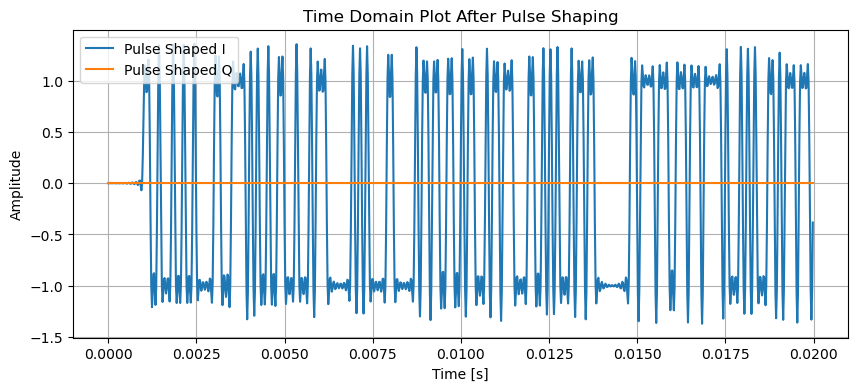

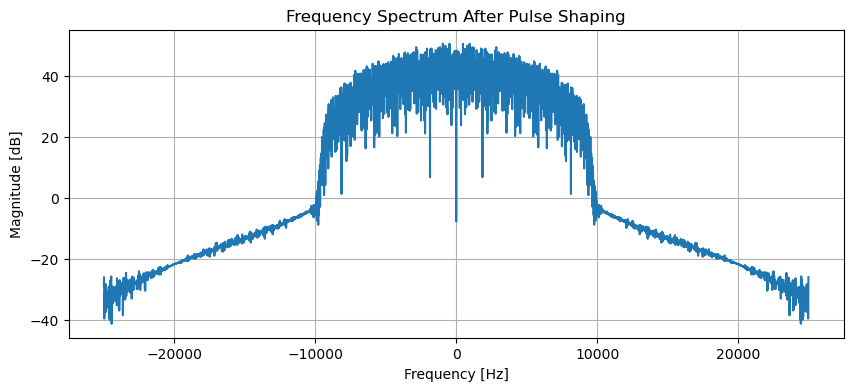

In [36]:
# ------------------------------------------------
# 3. PULSE SHAPING (Lowpass FIR Filter)
# ------------------------------------------------
num_taps = 101
rrc_filter = firwin(num_taps, data_rate/(fs/2), window='hamming')
pulse_shaped_i = lfilter(rrc_filter, 1.0, i_signal)
pulse_shaped_q = lfilter(rrc_filter, 1.0, q_signal)

# --- Time-domain plot after pulse shaping ---
plt.figure(figsize=(10, 4))
plt.plot(time[:1000], pulse_shaped_i[:1000], label='Pulse Shaped I')
plt.plot(time[:1000], pulse_shaped_q[:1000], label='Pulse Shaped Q')
plt.title('Time Domain Plot After Pulse Shaping')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# --- Frequency domain after pulse shaping ---
fft_shaped = fft(pulse_shaped_i)
plt.figure(figsize=(10, 4))
plt.plot(fftshift(freqs), 20*np.log10(np.abs(fftshift(fft_shaped)) + 1e-6))
plt.title('Frequency Spectrum After Pulse Shaping')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.show()

## 4. Constellation Diagram
BPSK symbols appear along the I-axis, since Q = 0. The constellation shows symbol separation and noise resilience.

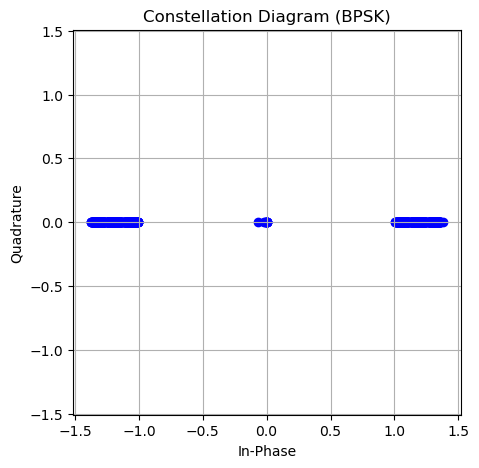

In [31]:
# ------------------------------------------------
# 4. CONSTELLATION DIAGRAM
# ------------------------------------------------
# Downsample to symbol rate for constellation
sampled_i = pulse_shaped_i[samples_per_symbol//2::samples_per_symbol]
sampled_q = pulse_shaped_q[samples_per_symbol//2::samples_per_symbol]

plt.figure(figsize=(5, 5))
plt.scatter(sampled_i, sampled_q, color='blue')
plt.title('Constellation Diagram (BPSK)')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')
plt.show()


## 5. SDR Configuration
**Transmitter and Receiver Configuration:**
PlutoSDR is configured for center frequency = 169 MHz, bandwidth = 2 MHz, and sample rate = 50 kHz.

In [34]:

# ------------------------------------------------
# 5. SDR TRANSMIT CODE
# ------------------------------------------------
from adi import pluto
sdr = pluto.Pluto()
sdr.tx_lo = int(fc)
sdr.sample_rate = fs
sdr.tx_rf_bandwidth = 2000000
sdr.tx_hardwaregain = -10
sdr.tx_cyclic_buffer = True
sdr.tx(pulse_shaped_i + 1j * pulse_shaped_q)

D:\Programming_Softwares\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
D:\Programming_Softwares\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
D:\Programming_Softwares\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


ImportError: cannot import name 'pluto' from 'adi' (D:\Programming_Softwares\anaconda3\Lib\site-packages\adi\__init__.py)